In [11]:
import pandas as pd
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt

# Data 

In [2]:
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)

X = mnist["data"]
y = mnist["target"].astype(np.uint8)

/Users/thor/anaconda3/envs/ds24/lib/python3.11/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

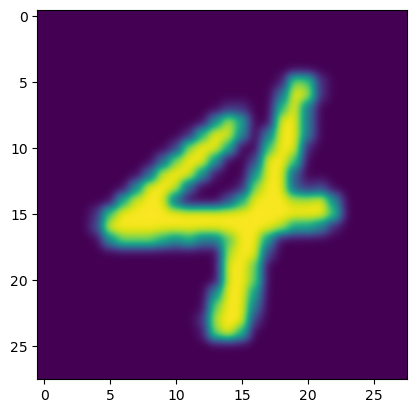

In [5]:

plt.imshow(X_train[0].reshape(28, 28), interpolation="gaussian")

In [8]:
rf_clf = RandomForestClassifier(n_jobs=-1)

et_clf = ExtraTreesClassifier(n_jobs=-1)

svm_clf = Pipeline([
    ("standarize", StandardScaler()),
    ("svc", SVC(verbose=2, gamma="scale"))
])

In [9]:
hard_voting_ensemble = VotingClassifier(estimators=[
    ("random_forest", rf_clf),
    ("extra_trees", et_clf),
    ("svm", svm_clf)
], voting="hard")

In [10]:
estimators = [rf_clf, et_clf, svm_clf, hard_voting_ensemble]

for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

[estimator.score(X_val, y_val) for estimator in estimators]

Training the RandomForestClassifier(n_jobs=-1)
Training the ExtraTreesClassifier(n_jobs=-1)
Training the Pipeline(steps=[('standarize', StandardScaler()), ('svc', SVC(verbose=2))])
[LibSVM]*
optimization finished, #iter = 532
obj = -86.158094, rho = -0.245230
nSV = 297, nBSV = 64
.*
optimization finished, #iter = 1804
obj = -278.056475, rho = 0.746646
nSV = 1006, nBSV = 228
.*
optimization finished, #iter = 1605
obj = -220.749384, rho = 0.566441
nSV = 819, nBSV = 169
*.*
optimization finished, #iter = 1157
obj = -160.855949, rho = 0.336361
nSV = 605, nBSV = 115
.*
optimization finished, #iter = 1678
obj = -284.728218, rho = 0.482714
nSV = 897, nBSV = 253
.*
optimization finished, #iter = 1718
obj = -292.705867, rho = 0.675282
nSV = 946, nBSV = 259
.*
optimization finished, #iter = 1442
obj = -164.484653, rho = 0.726158
nSV = 780, nBSV = 115
.*
optimization finished, #iter = 1450
obj = -251.497153, rho = 0.267313
nSV = 755, nBSV = 208
*.*
optimization finished, #iter = 1182
obj = -201.3

[0.9715, 0.9717, 0.9632, 0.9733]

In [ ]:
test_predict = hard_voting_ensemble.predict(X_test)

# Grid Search

In [ ]:
# k-Nearest Neighbors parameters
knn_params = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute']
}

knn_clf = KNeighborsClassifier()

# Updating models_params to include k-NN
models_params = [
    (RandomForestClassifier(n_jobs=-1), {
        'n_estimators': [100, 200],
        'max_depth': [None, 30, 50],
        'min_samples_split': [2, 5],
    }),
    (ExtraTreesClassifier(n_jobs=-1), {
        'n_estimators': [100, 200],
        'max_depth': [None, 30, 50],
        'min_samples_split': [2, 5],
    }),
    (Pipeline([
        ("standarize", StandardScaler()),
        ("svc", SVC(verbose=2, gamma="scale"))
    ]), {
        'svc__C': [1, 10, 20],
        'svc__kernel': ['rbf'],
    }),
    (knn_clf, knn_params)  # Adding k-NN classifier and its parameters
]

# Perform grid search for each model
for model, params in models_params:
    grid_search = GridSearchCV(model, params, cv=3, scoring='accuracy', verbose=2)
    grid_search.fit(X, y)
    print(f"Best parameters for {model.__class__.__name__}: {grid_search.best_params_}")
    print(f"Best score for {model.__class__.__name__}: {grid_search.best_score_}")
